## Import Modules

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import imutils
import time

In [3]:
# load and preprocess the image
def load_and_preprocess(image_path):
    image = cv2.imread(image_path)
    image = cv2.resize(image, (1280, 720))
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return image, gray_image

# subtract images
def subtract_images(image1, image2):
    diff = cv2.absdiff(image1, image2)
    _, thresh = cv2.threshold(diff, 50, 255, cv2.THRESH_BINARY)
    return diff, thresh

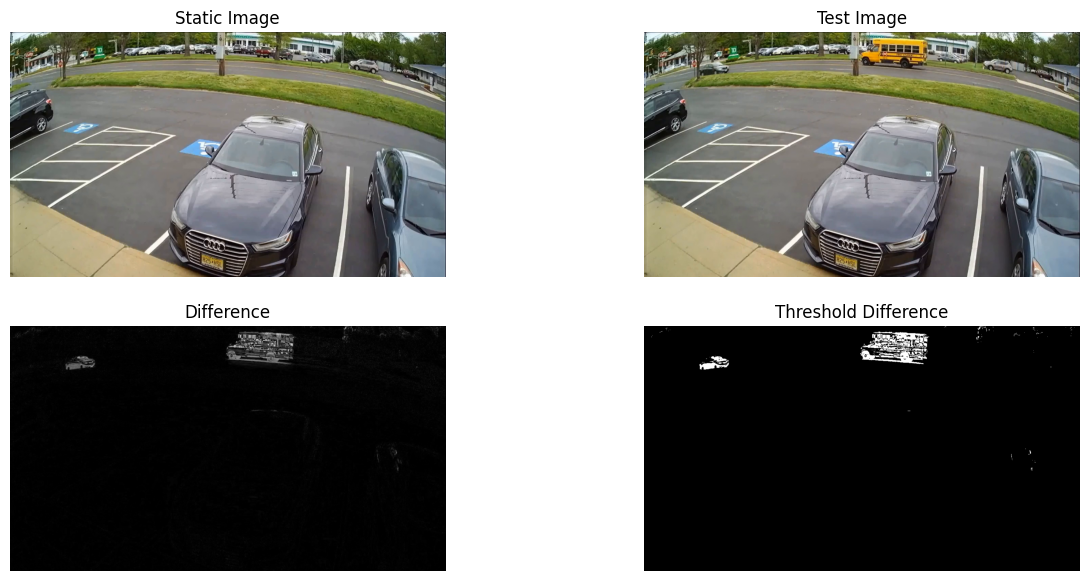

In [4]:
image_path1 = 'static.png'
image_path2 = 'test.png'

image1, gray_image1 = load_and_preprocess(image_path1)
image2, gray_image2 = load_and_preprocess(image_path2)

# subtract the images
diff, thresh = subtract_images(gray_image1, gray_image2)

# plot the images
plt.figure(figsize=(15, 7))

plt.subplot(2, 2, 1)
plt.title('Static Image')
plt.imshow(cv2.cvtColor(image1, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(2, 2, 2)
plt.title('Test Image')
plt.imshow(cv2.cvtColor(image2, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(2, 2, 3)
plt.title('Difference')
plt.imshow(diff, cmap='gray')
plt.axis('off')

plt.subplot(2, 2, 4)
plt.title('Threshold Difference')
plt.imshow(thresh, cmap='gray')
plt.axis('off')

plt.show()

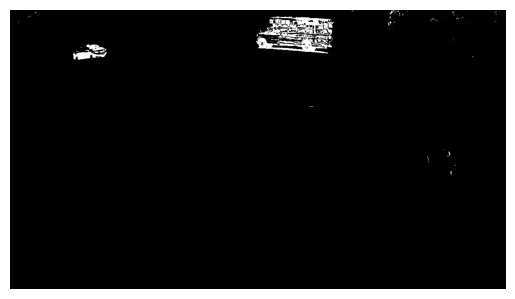

In [5]:
dilated_image = cv2.dilate(thresh, None, iterations=0)
plt.imshow(dilated_image, cmap='gray')
plt.axis('off')
plt.show()

In [6]:
cnts = cv2.findContours(dilated_image.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
#cnts

In [7]:
# iterate the contours
for c in cnts:
    if cv2.contourArea(c) < 700:
        continue

    # get the bounding box coordinates
    (x, y, w, h) = cv2.boundingRect(c)
    cv2.rectangle(image2, (x, y), (x+w, y+h), (0, 255, 0), 2)

cv2.imshow('test', image2)
cv2.waitKey(10000)
cv2.destroyAllWindows()

## Test in Realtime / Video

In [33]:
video_path = 'test.mp4'
#video_cap = cv2.VideoCapture(0) # capture from webcam
video_cap = cv2.VideoCapture(video_path)
static_frame = None

min_contour_area = 700  # Minimum contour area to consider as a car

#frame_count = 0
#update_interval = 30

while True:
    success, frame = video_cap.read()
    if not success:
        break

    frame = cv2.resize(frame, (1280, 720))
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    if static_frame is None:
        static_frame = gray_frame
        continue

    #if static_frame is None or frame_count % update_interval == 0:
        #static_frame = gray_frame
        #frame_count += 1
        #continue

    # get the subtract frames
    diff, thresh = subtract_images(static_frame, gray_frame)
    dilated_image = cv2.dilate(thresh, None, iterations = 2)

    # get contours
    cnts = cv2.findContours(dilated_image.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)

    # iterate the contours
    for c in cnts:
        if cv2.contourArea(c) < min_contour_area:
            continue
    
        # get the bounding box coordinates
        (x, y, w, h) = cv2.boundingRect(c)
        cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)


    cv2.imshow("Motion Detection", frame)

    # exit if any key is pressed
    if cv2.waitKey(1) & 0xFF != 255:
        break
    time.sleep(0.1)

#frame_count += 1

video_cap.release()
cv2.destroyAllWindows()

Resoudre les mouvements en background

In [25]:
video_path = 'test.mp4'
video_cap = cv2.VideoCapture(video_path)
static_frame = None
min_contour_area = 700


fgbg = cv2.createBackgroundSubtractorMOG2(history=500, varThreshold=50, detectShadows=True)


while True:
    success, frame = video_cap.read()
    if not success:
        break

    frame = cv2.resize(frame, (1280, 720))
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    if static_frame is None:
        static_frame = gray_frame
        continue
    
    # Apply background subtraction
    fgmask = fgbg.apply(gray_frame)

    # Apply morphological operations to remove noise
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    #   0 0 1 0 0
    #   0 1 1 1 0
    #   1 1 1 1 1
    #   0 1 1 1 0
    #   0 0 1 0 0
    fgmask = cv2.morphologyEx(fgmask, cv2.MORPH_CLOSE, kernel)
    fgmask = cv2.morphologyEx(fgmask, cv2.MORPH_OPEN, kernel)

    dilated_image = cv2.dilate(fgmask, None, iterations=2)

    cnts = cv2.findContours(dilated_image.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)

    for c in cnts:
        if cv2.contourArea(c) < min_contour_area:
            continue

        (x, y, w, h) = cv2.boundingRect(c)
        cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)


    cv2.imshow("Motion Detection", frame)

    if cv2.waitKey(1) & 0xFF != 255:
        break
    time.sleep(0.1)


video_cap.release()
cv2.destroyAllWindows()

Calcule du nombre du voiture

In [27]:
video_path = 'test.mp4'
video_cap = cv2.VideoCapture(video_path)
static_frame = None
min_contour_area = 700
fgbg = cv2.createBackgroundSubtractorMOG2(history=500, varThreshold=50, detectShadows=True)


car_count = 0 # Initialize car count to 0

while True:
    success, frame = video_cap.read()
    if not success:
        break

    frame = cv2.resize(frame, (1280, 720))
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    if static_frame is None:
        static_frame = gray_frame
        continue

    fgmask = fgbg.apply(gray_frame)

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    fgmask = cv2.morphologyEx(fgmask, cv2.MORPH_CLOSE, kernel)
    fgmask = cv2.morphologyEx(fgmask, cv2.MORPH_OPEN, kernel)

    dilated_image = cv2.dilate(fgmask, None, iterations=2)

    cnts = cv2.findContours(dilated_image.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)

    for c in cnts:
        if cv2.contourArea(c) < min_contour_area:
            continue
    
        (x, y, w, h) = cv2.boundingRect(c)
        cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)

        # Increment car count
        car_count += 1

    # Display the car count
    cv2.putText(frame, f"Cars: {car_count}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

    cv2.imshow("Motion Detection", frame)

    if cv2.waitKey(1) & 0xFF != 255:
        break
    time.sleep(0.1)

    

video_cap.release()
cv2.destroyAllWindows()

Calcule Voiture (Solution):

Car speed

C:\Users\sebba\AppData\Local\Temp\ipykernel_8336\304678479.py:86: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predicted_center = (int(predicted[0]), int(predicted[1]))
